In [1]:
import pandas as pd
import os
from surprise import Reader, Dataset, SVD
from surprise.accuracy import rmse,mae
from surprise.model_selection import cross_validate

import matplotlib.pyplot as plt
from collections import defaultdict


%matplotlib inline

### Import data sets, remove NaNs, rename columns, convert types

In [52]:
df_ratings = pd.read_csv('data/ratings_small.csv', usecols = ['userId','movieId', 'rating']) #do not import the timestamp col
df_meta = pd.read_csv('data/movies_metadata.csv', usecols = ['id','title'])

df_meta.rename(columns={'id': 'movieId'}, inplace=True)

df_ratings = df_ratings.dropna(subset=['userId', 'movieId', 'rating']) #remove any NaN
df_meta = df_meta.dropna(subset=['movieId','title']) #drop any rows where title is a NaN - 6 titles in total

df_ratings[['userId','movieId']] = df_ratings[['userId','movieId']].astype(int)
df_ratings['rating'] = df_ratings['rating'].astype(float)#convert from string to float
df_meta['movieId'] = df_meta['movieId'].astype(int) #convert strings to ints 

print(df_ratings.shape)
print(df_meta.shape)

(100004, 3)
(45460, 2)


### Exploratory Data Analysis

In [53]:
number_of_unique_movies = df_ratings['movieId'].nunique()
number_of_unique_users = df_ratings['userId'].nunique()
print(number_of_unique_movies)
print(number_of_unique_users)

9066
671


### Sparcity of the dataset
Sparsity (%) = (no of missing values / total values) * 100

In [54]:
# calculate the data sparcity of the matrix, how many zeros are there in the 
#matrix number of movies x number of users
# preferable to have low sparsity, up to 99.5% sparcity ok for the svd model

available_ratings = df_ratings['rating'].count()
total_ratings = number_of_unique_movies * number_of_unique_users
missing_ratings = total_ratings - available_ratings
sparsity = (missing_ratings/total_ratings)*100
print("Sparsity of dataset: {}%".format(round(sparsity, 2)))

Sparsity of dataset: 98.36%


### Ratings Distribution

(100004, 3)


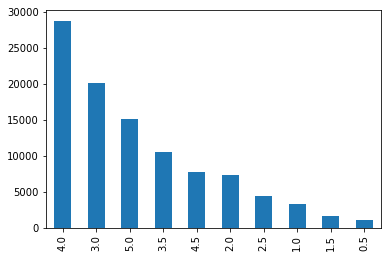

In [55]:
df_ratings['rating'].value_counts().plot(kind = 'bar')
print(df_ratings.shape)

### Dimensionality Reduction

In [56]:
#Filter movies with less than 3 ratings
print(df_ratings.shape)
filter_movies = df_ratings['movieId'].value_counts() > 3
filter_movies = filter_movies[filter_movies].index.tolist()
print("Number of movies with >3 ratings: {}".format(len(filter_movies)))

#filter users with less than 3 movies rated

filter_users = df_ratings['userId'].value_counts() > 3
filter_users = filter_users[filter_users].index.tolist()
print("Number of user with >3 ratings: {}".format(len(filter_users)))

# remove rarely rated movies and rarely rated users
df_ratings = df_ratings[(df_ratings['movieId'].isin(filter_movies)) & (df_ratings['userId'].isin(filter_users))]
print(df_ratings.shape)

#number of ratings  to process has dropped from 100004 > 92272
# only 8% of data has been filtered

(100004, 3)
Number of movies with >3 ratings: 4046
Number of user with >3 ratings: 671
(92272, 3)


### Training the data with test sets

In [57]:
#Columns used for training
cols = ['userId', 'movieId', 'rating']

#create a surpise reader using the surprise library, max/min rating scale cardinal
reader = Reader(rating_scale = (0.5, 5))

#import the data using surpse Dataset object
data = Dataset.load_from_df(df_ratings[cols], reader)

#create the training-set and prediction-set using complete dataset
#use trainset to train model
trainset = data.build_full_trainset()

# antiset used for predictions
# a antiset that contains colbination of movies and user where there is no rating
# contains pairs of user/movie that do not have a rating yet and require a prediction.
antiset = trainset.build_anti_testset()



### Create an SVD model

In [58]:
# SVD  (Singular Value Decomposition)
# each row represetns a user, each column repesetns and item(movie). Interaction MAtrix
# SVD is a matrix decompostion method for reducing a mtrix into its consituent parts
# SVD takes a interaction matrix and factorizes into 3 matrices,
# Interaction matrix = A x B x C
# Takes a sparse interaction matrix, factorizes  into 3 matrixes, then multiple factors back to form interaction matrix estimation

#number of epochs, model tries fit model over data 25 time, trying to reduce errors
algo = SVD(n_epochs = 25, verbose = True)

#Training the model
# cross validation, re-sampling procedure to evaulate machine laerning mdoels.
# divide data into k parts, using k-1 parts to train and 1 part to test
# each time taking a different part for testing
# k = 5, 4 parts train, 1 part test,
# results in less bias model, each observation in the data set has a chance of appearing in the traing and teting set

#MEan Absolute Error - avergae magnituede of the errors in a set of predictions without consdering direction
#Root Mean Squared Error - sqaure root of average sqaured differecne bewteen prediciton and observation


cross_validate(algo, data, measures = ['RMSE', 'MAE'], cv = 5, verbose= True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 0
P

{'fit_time': (7.334821939468384,
  7.145766019821167,
  7.932235956192017,
  7.346879005432129,
  7.828912973403931),
 'test_mae': array([0.6855648 , 0.67711135, 0.68257321, 0.68080657, 0.680648  ]),
 'test_rmse': array([0.89257521, 0.87884848, 0.88719234, 0.88538872, 0.88652576]),
 'test_time': (0.19726896286010742,
  0.18092703819274902,
  0.253314733505249,
  0.17211699485778809,
  0.17277312278747559)}

### Predctions

In [59]:
# Predcit raiting for all pairs (users, items) that are NOT in the trianing set

predictions = algo.test(antiset)

In [60]:
def getRecommendations(userID, n, predictions):

    user1 = []
    for uid, iid, _, est, _ in predictions:
        if uid == userID:
            user1.append((uid, iid, est))
    df1 = pd.DataFrame(user1, columns = ['userId','movieId', 'predRating'])
    df1 = df1.sort_values('predRating', ascending=False)
    df1 = df1.head(n)

    print("UserID: {}".format(userID))

    print("Top 3 recommended movies to watch next...")
    for index, row in df1.iterrows():
        movieid = int(row['movieId'])
        pred_rating = row['predRating']
        print("{}, {}, {}".format(movieid, getMovieTitle(movieid), round(pred_rating,2)))
    

In [61]:
def getMovieTitle(movieId):
    df_title = df_meta.loc[df_meta['movieId'] == movieId]
    if len(df_title) == 0:
        title = "Unknown"
    else:
        title = df_title.iloc[0,1]
    return title

In [68]:
userID = 6

getRecommendations(userID, 3, predictions)

UserID: 6
Top 3 recommended movies to watch next...
969, Unknown, 4.27
1213, The Talented Mr. Ripley, 4.21
1217, Unknown, 4.19


In [ ]:
TO DO
links.csv and meta data.csv. merge on ids and get titles.